## Monut

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys

# TODO: change this to the path to your homework folder
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '487Final'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))
os.chdir(GOOGLE_DRIVE_PATH)

['Media_web_crawling.ipynb', 'GPE_Media_Reference.gsheet', 'dataset', '487FinalProject.ipynb']


## Load Libraries

In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Load Dataset

In [ ]:
data = pd.read_csv("dataset/cleaned_10k_data.csv")
data.sample(5)

,Sentiment,Text
5027,1,Hey! Vote for ! He's currently in 3rd place!...
476,0,"realised that Nestle make Fruit Pastilles, whi..."
9959,1,is running the race for life and vote for me...
5635,1,R for my movie!!
6143,1,Well this is the first time EngDems have stoo...


In [ ]:
# from sklearn.model_selection import train_test_split

# X = data.Text.values
# y = data.Sentiment.values

# X_train, X_val, y_train, y_val =\
#     train_test_split(X, y, test_size=0.1, random_state=2020)

## Load Train Data

In [ ]:
label_1_data = data[data['Sentiment'] == 1]
label_0_data = data[data['Sentiment'] == 0]

# Split each label group into train and test sets
train_1 = label_1_data.sample(4500)
train_0 = label_0_data.sample(4500)
test_1 = label_1_data.drop(train_1.index)
test_0 = label_0_data.drop(train_0.index)

# Combine the train and test sets
train_data = pd.concat([train_1, train_0])
test_data = pd.concat([test_1, test_0])

# Shuffle the train and test data
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

In [ ]:
from sklearn.model_selection import train_test_split

X = train_data.Text.values
y = train_data.Sentiment.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.2, random_state=2020)

In [ ]:
test_data.shape

(1000, 2)

## Set up GPU for training

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


## Baseline: Naive Bayes & TF-IDF

In [ ]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Train Naive Bayes

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

CPU times: user 12.3 s, sys: 1.59 s, total: 13.9 s
Wall time: 14.1 s


#### Search Hyperparameters

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

Best alpha:  1.6


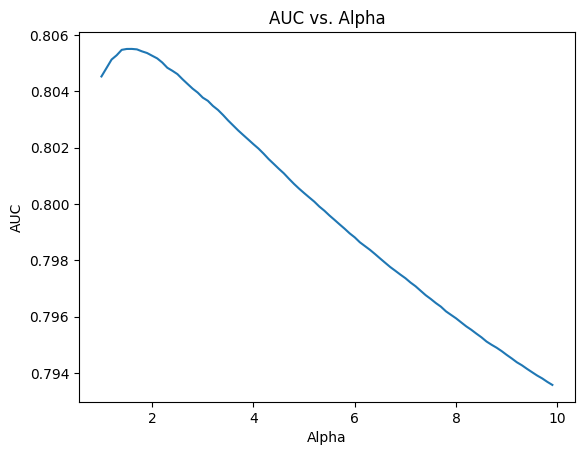

In [ ]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(alpha = i))
                 for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

#### Evaluation on Validation set

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.7948
Accuracy: 71.72%


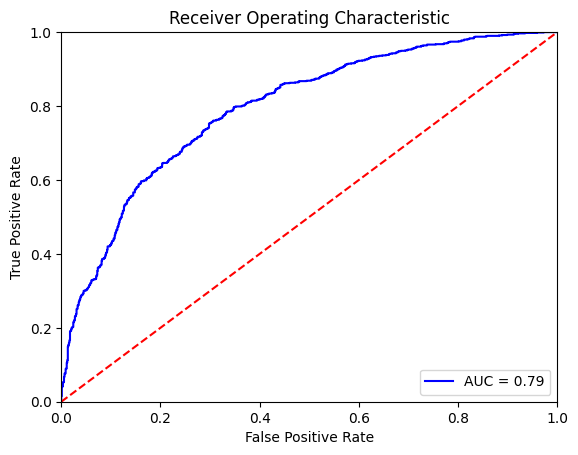

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

## Fine-Tuning BERT

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 8.8 MB/s eta 0:00:00


## Tokenization

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# Concatenate train data and test data
all_tweets = np.concatenate([data.Text.values, test_data.Text.values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  102


In [ ]:
# Specify `MAX_LEN`
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:   Lala seems good, but waiting for it to be available to those outside the US 
Token IDs:  [101, 21348, 2050, 3849, 2204, 1010, 2021, 3403, 2005, 2009, 2000, 2022, 2800, 2000, 2216, 2648, 1996, 2149, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Create PyTorch DataLoader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

##Train Model

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 66.5 ms, sys: 2.03 ms, total: 68.5 ms
Wall time: 82 ms


##Optimizer & Scheduler

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

##Training

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=5)
train(bert_classifier, train_dataloader, val_dataloader, epochs=5, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.638039   |     -      |     -     |   9.93   
   1    |   40    |   0.541957   |     -      |     -     |   5.93   
   1    |   60    |   0.507704   |     -      |     -     |   5.94   
   1    |   80    |   0.533181   |     -      |     -     |   5.94   
   1    |   100   |   0.434301   |     -      |     -     |   5.99   
   1    |   120   |   0.432702   |     -      |     -     |   5.98   
   1    |   140   |   0.474053   |     -      |     -     |   6.01   
   1    |   160   |   0.407708   |     -      |     -     |   6.03   
   1    |   180   |   0.474156   |     -      |     -     |   6.06   
   1    |   200   |   0.396336   |     -      |     -     |   6.09   
   1    |   220   |   0.448641   |     -      |     -     |   6.09   
   1    |   224   |   0.426939   |     -      |     -     |   1.22   


##Evaluation on Validation

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

AUC: 0.8798
Accuracy: 80.61%


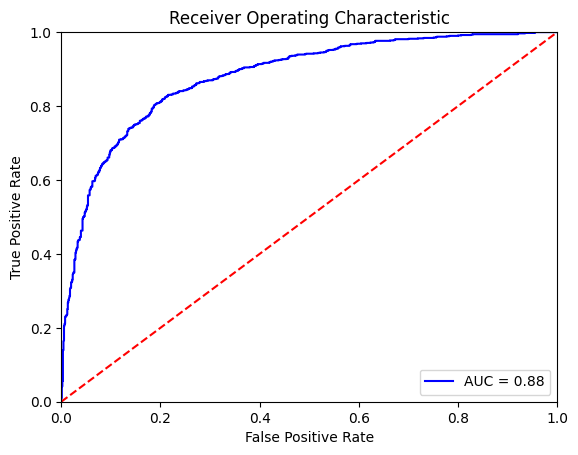

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

##Training on Entire Training Data

In [ ]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=5)
train(bert_classifier, full_train_dataloader, epochs=5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.639659   |     -      |     -     |   6.85   
   1    |   40    |   0.490189   |     -      |     -     |   6.47   
   1    |   60    |   0.487794   |     -      |     -     |   6.45   
   1    |   80    |   0.379667   |     -      |     -     |   6.49   
   1    |   100   |   0.488957   |     -      |     -     |   6.46   
   1    |   120   |   0.457118   |     -      |     -     |   6.48   
   1    |   140   |   0.448276   |     -      |     -     |   6.45   
   1    |   160   |   0.465277   |     -      |     -     |   6.49   
   1    |   180   |   0.476277   |     -      |     -     |   6.46   
   1    |   200   |   0.417557   |     -      |     -     |   6.47   
   1    |   220   |   0.386619   |     -      |     -     |   6.47   
   1    |   240   |   0.476587   |     -      |     -     |   6.48   


##Test on Test Set

In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.Text)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.8
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())
print("Accuracy of non-negative out of 500: ", (preds.sum())/ 500)

Number of tweets predicted non-negative:  466
Accuracy of non-negative out of 500:  0.932


##Prediction

In [ ]:
import numpy as np
import pandas as pd
import glob
import os

file_path = 'dataset/Cleaned_Web_Crawled_Dataset/*.csv'
data_vectors = {}

for file_name in glob.glob(file_path):
    base_name = os.path.basename(file_name)  # Get the file name without the path
    
    file_key = os.path.splitext(base_name)[0]  # Remove the extension from the file name
    # print(file_name)
    df = pd.read_csv(file_name)
    data_vector = df['Text']
    pred_inputs, pred_masks = preprocessing_for_bert(data_vector)

    # Create the DataLoader for our test set
    pred_dataset = TensorDataset(pred_inputs, pred_masks)
    pred_sampler = SequentialSampler(pred_dataset)
    pred_dataloader = DataLoader(pred_dataset, sampler=pred_sampler, batch_size=32)
    probs = bert_predict(bert_classifier, pred_dataloader)
    threshold = 0.6
    preds = np.where(probs[:, 1] > threshold, 1, 0)
    data_vectors[file_key] = preds.sum()/len(preds)

In [ ]:
data_vectors

{'nytimes_Ukraine_data': 0.28169014084507044,
 'nytimes_China_data': 0.15,
 'WSJ_Russia_data': 0.2112676056338028,
 'TheEconomist_Russia_data': 0.20430107526881722,
 'WSJ_USA_data': 0.9,
 'globaltimesnews_Ukraine_data': 0.2727272727272727,
 'CNN_USA_data': 0.2482758620689655,
 'TheEconomist_USA_data': 0.4090909090909091,
 'nytimes_USA_data': 0.7419354838709677,
 'BBCWorld_USA_data': 0.20512820512820512,
 'Reuters_China_data': 0.1762820512820513,
 'CNN_China_data': 0.14285714285714285,
 'XHNews_China_data': 0.7413793103448276,
 'TheEconomist_China_data': 0.30601092896174864,
 'globaltimesnews_USA_data': 0.27467811158798283,
 'Reuters_USA_data': 0.3709677419354839,
 'CGTNOfficial_China_data': 0.680635838150289,
 'PDChina_USA_data': 0.22,
 'globaltimesnews_China_data': 0.5284653465346535,
 'XHNews_USA_data': 0.5277777777777778,
 'BBCWorld_China_data': 0.16279069767441862,
 'SCMPNews_USA_data': 0.22682926829268293,
 'WSJ_China_data': 0.14814814814814814,
 'ChinaDaily_USA_data': 0.323170731

In [ ]:

twitter_accounts = ['CNN', 'nytimes', 'BBCWorld', 'TheEconomist', 'Reuters', 'WSJ', 'CGTNOfficial', 'XHNews', 'globaltimesnews', 'SCMPNews', 'ChinaDaily', 'PDChina']
GPE = ['USA', 'China', 'Taiwan', 'Russia', 'Ukraine']

print(GPE)
print(twitter_accounts)

['USA', 'China', 'Taiwan', 'Russia', 'Ukraine']
['CNN', 'nytimes', 'BBCWorld', 'TheEconomist', 'Reuters', 'WSJ', 'CGTNOfficial', 'XHNews', 'globaltimesnews', 'SCMPNews', 'ChinaDaily', 'PDChina']


In [ ]:
table = pd.DataFrame(index=twitter_accounts, columns=GPE, dtype=float)

for key, value in data_vectors.items():
    account, country = key.split('_')[:2]  # Extract the account and country from the key
    if account in table.index and country in table.columns:
        table.at[account, country] = value

In [ ]:
print(table)

                      USA     China    Taiwan    Russia   Ukraine
CNN              0.248276  0.142857  0.000000  0.302326  0.300000
nytimes          0.741935  0.150000  0.000000  0.276596  0.281690
BBCWorld         0.205128  0.162791  0.000000  0.122449  0.244186
TheEconomist     0.409091  0.306011  0.272727  0.204301  0.346734
Reuters          0.370968  0.176282  0.240000  0.218543  0.196203
WSJ              0.900000  0.148148  0.000000  0.211268  0.102273
CGTNOfficial     0.543210  0.680636  0.500000  0.215190  0.240000
XHNews           0.527778  0.741379  0.666667  0.433333  0.187500
globaltimesnews  0.274678  0.528465  0.295082  0.576923  0.272727
SCMPNews         0.226829  0.264596  0.156250  0.250000  0.223301
ChinaDaily       0.323171  0.609524  0.520000  0.571429  0.500000
PDChina          0.220000  0.795359  0.500000  0.588235  0.200000


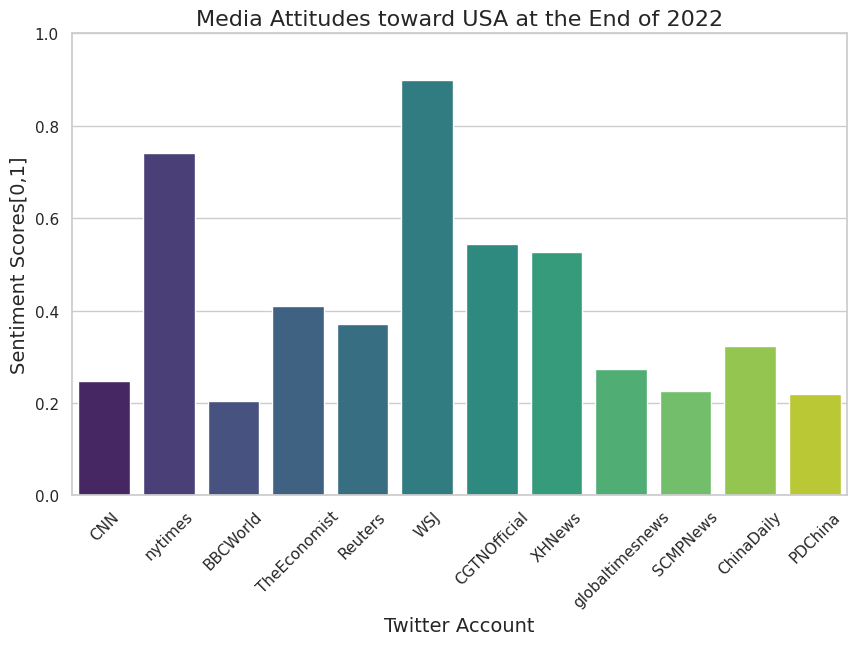

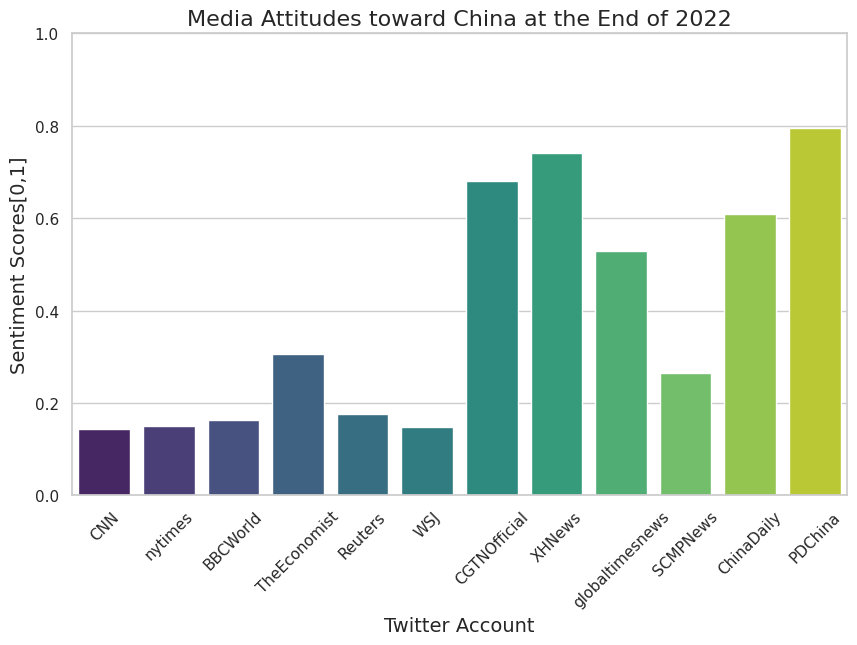

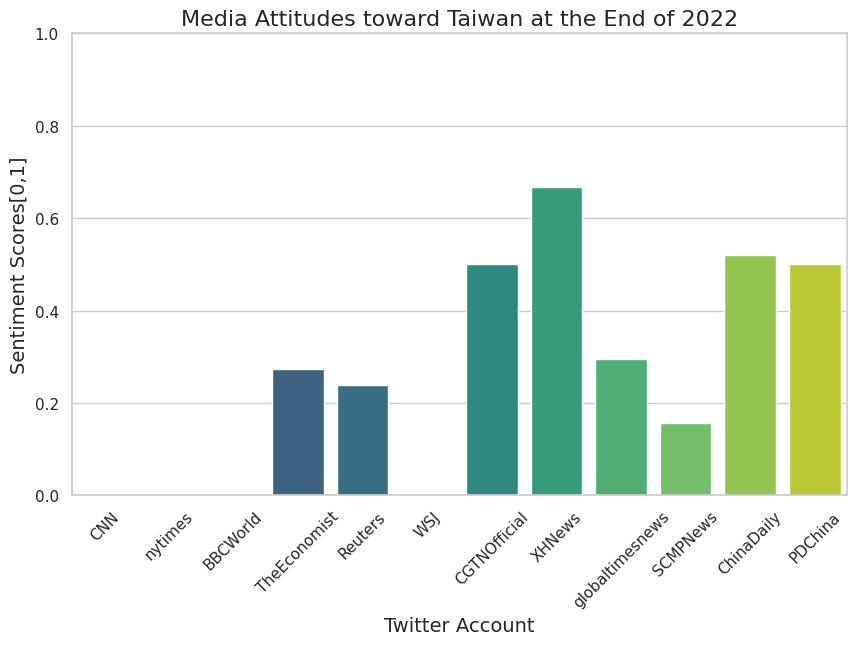

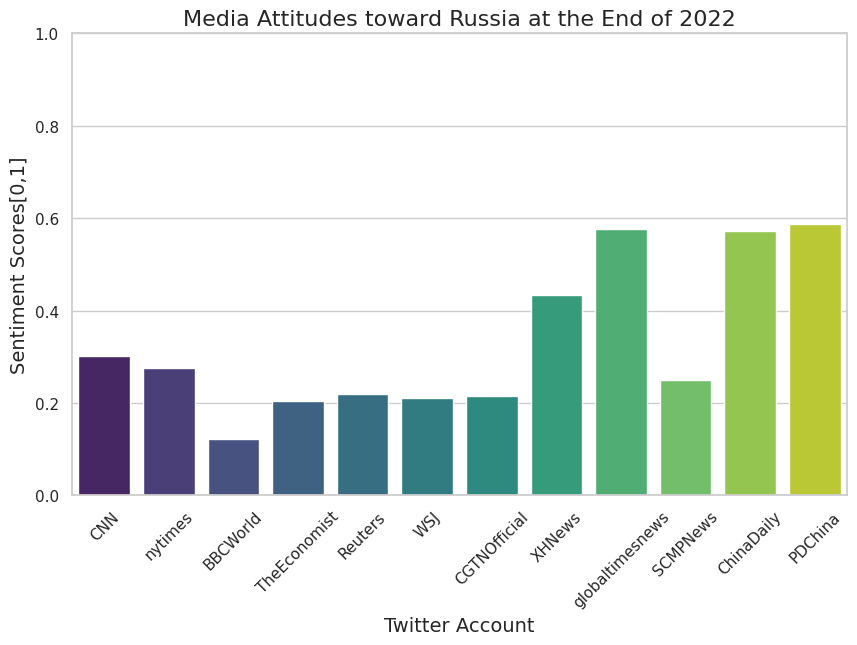

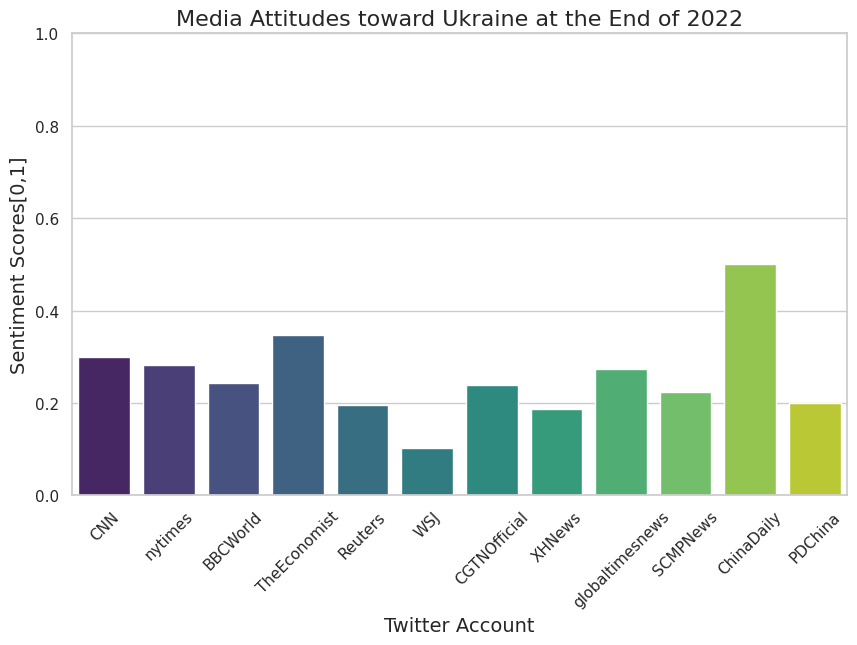

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
›
# Assuming 'table' is the DataFrame you created earlier

# Set the background style for seaborn
sns.set_theme(style="whitegrid")

# Loop through the countries and create a bar plot for each
for country in table.columns:
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(x=table.index, y=table[country], palette='viridis')
    
    # Set the title and labels
    barplot.set_title(f"Media Attitudes toward {country} at the End of 2022", fontsize=16)
    barplot.set_xlabel("Twitter Account", fontsize=14)
    barplot.set_ylabel("Sentiment Scores[0,1]", fontsize=14)
    
    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    # Show the plot
    plt.show()
